# Demo

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import financial.data as fd
import financial.model as fm

import numpy as np
import pandas as pd
import os

2025-04-25 20:37:20.970408: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-25 20:37:20.971098: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-25 20:37:20.981098: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-25 20:37:21.111747: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-25 20:37:23.637791: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

In [3]:
from dotenv import load_dotenv
from financial.momentum.utilities import find_dotenv
load_dotenv(dotenv_path=find_dotenv())

True

In [4]:
from financial.io.cache import NoUpdateStrategy
from financial.io.file.cache import FileCache

print(os.environ["DATA"])
print(os.environ["CACHE"])
ds = fd.CachedDataStore(path=os.environ["DATA"], cache=FileCache(cache_path=os.environ["CACHE"]+"/", update_strategy=NoUpdateStrategy()))

print(ds)

/home/manidmt/Universidad/TFG/OTRI/data
/home/manidmt/Universidad/TFG/OTRI/cache
CachedDataStore with 946 data sources [cache stats: {'size': 0, 'hit': 0, 'miss': 0, 'write': 0, 'read': 0, 'update': 0}]


## Acceso a los datos

In [5]:
# Datos históricos de un ticker concreto, p.ej. ^GSPC (S&P 500)
start_date = '1990-01-01'
end_date = '2023-12-31'
ticker = '^GSPC'

data = ds.get_data(ticker, start_date, end_date)
print(data)

1990-01-02     359.690002
1990-01-03     358.760010
1990-01-04     355.670013
1990-01-05     352.200012
1990-01-08     353.790009
                 ...     
2023-12-22    4754.629883
2023-12-26    4774.750000
2023-12-27    4781.580078
2023-12-28    4783.350098
2023-12-29    4769.830078
Name: ^GSPC, Length: 8565, dtype: float64


^GSPC, from 1990-01-02 to 2023-12-29


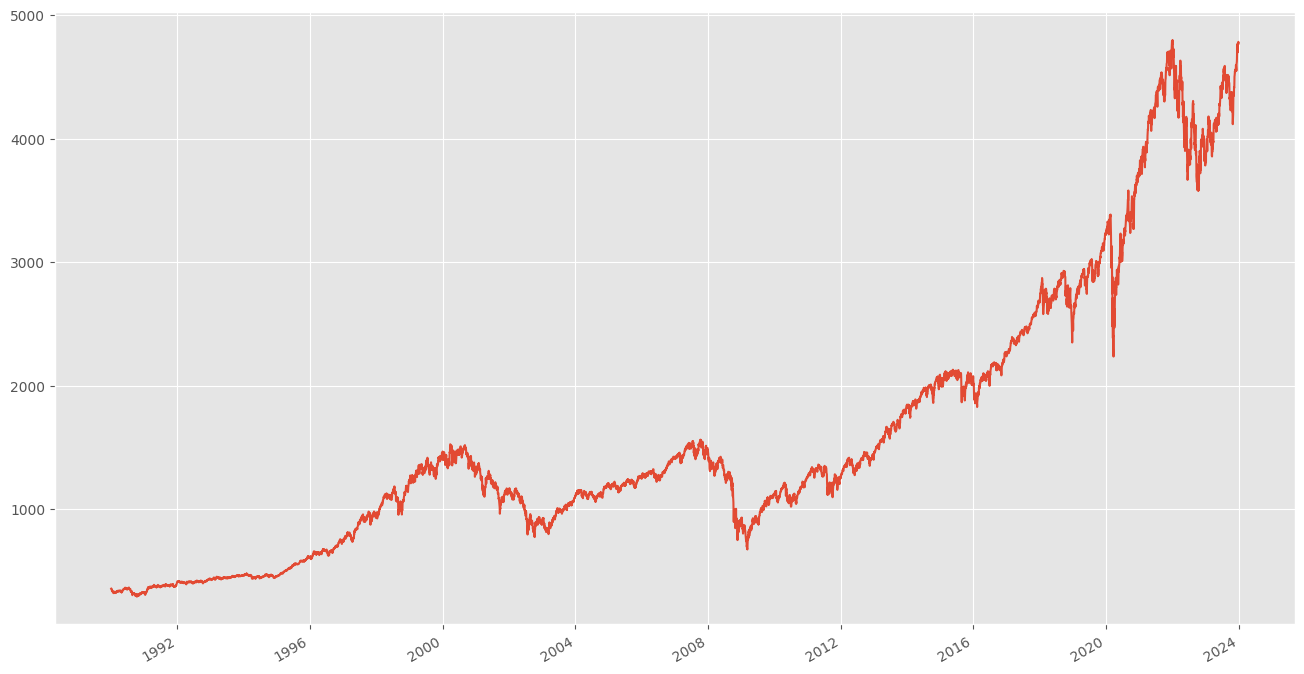

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl

mpl.rc('figure', figsize=(16, 9))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')


def plot_data(data: pd.Series) -> None:
    data.plot()
    start_date = data.index[0].date()
    end_date = data.index[-1].date()
    print(f"{data.name}, from {start_date} to {end_date}")

plot_data(data)

# Hiperparámetros

In [7]:
# Declarative model specification

experiment_id = 'ar-model'
lookahead = 20 # i.e. ~ 1 mes (4 semanas)
horizon   = 90 # i.e. ~ 1 mes (4 semanas)

hyperparameters = {
        "input": {
            "features": "baseline_features",
            "horizon": horizon,
            "ticker": ticker,
            #"normalization": { "method": "z-score", "start_index": start_date, "end_index": end_date }
            },
        "output": {
            "target": [ticker],
            "lookahead": lookahead,
            "prediction": "relative", # "absolute"|"relative"
            #"normalization": { "method": "z-score", "start_index": start_date, "end_index": end_date }
            },    
}

print(f"Experiment '{experiment_id}'")
print(hyperparameters)

Experiment 'ar-model'
{'input': {'features': 'baseline_features', 'horizon': 90, 'ticker': '^GSPC'}, 'output': {'target': ['^GSPC'], 'lookahead': 20, 'prediction': 'relative'}}


# E/S de un modelo autorregresivo

In [8]:
# Entradas 

def baseline_features(ds: fd.DataStore, hyperparameters: dict) -> fd.Set:
    features = fd.Set('Baseline features')
    
    ticker = hyperparameters["input"]["ticker"]
    horizon = hyperparameters["input"]["horizon"]
    #features.append(variable)
    variable = fd.Variable(ticker)
    for i in range(1, horizon+1): 
        features.append( fd.Change(variable, i) )

    return features

'''
print("MODEL INPUTS")
inputs = baseline_features(ds,hyperparameters)
print(inputs)
print(inputs.to_xml_string())

from financial.lab.preprocessing import DataStoreDataNormalization

def standardized_features(ds: fd.DataStore, features: fd.Set) -> fd.Set:
    if "normalization" in hyperparameters["input"]:
        normalization = hyperparameters["input"]["normalization"]
        method = normalization["method"]
        start_index = normalization["start_index"]
        end_index = normalization["end_index"]
        normalizer = DataStoreDataNormalization("ModelFactory", ds, features, method, start_index, end_index)
        features = normalizer.normalized()
    return features



print("STANDARDIZED MODEL INPUTS")
standardized_inputs = standardized_features(ds, inputs)
print(standardized_inputs)
print(standardized_inputs.to_xml_string())
'''

'\nprint("MODEL INPUTS")\ninputs = baseline_features(ds,hyperparameters)\nprint(inputs)\nprint(inputs.to_xml_string())\n\nfrom financial.lab.preprocessing import DataStoreDataNormalization\n\ndef standardized_features(ds: fd.DataStore, features: fd.Set) -> fd.Set:\n    if "normalization" in hyperparameters["input"]:\n        normalization = hyperparameters["input"]["normalization"]\n        method = normalization["method"]\n        start_index = normalization["start_index"]\n        end_index = normalization["end_index"]\n        normalizer = DataStoreDataNormalization("ModelFactory", ds, features, method, start_index, end_index)\n        features = normalizer.normalized()\n    return features\n\n\n\nprint("STANDARDIZED MODEL INPUTS")\nstandardized_inputs = standardized_features(ds, inputs)\nprint(standardized_inputs)\nprint(standardized_inputs.to_xml_string())\n'

In [9]:
# Salidas 

def output_descriptor(hyperparameters: dict, ds: fd.DataStore = None) -> fd.DataDescriptor:
    outputs = fd.Set('outputs')
    for output in hyperparameters["output"]["target"]:
        variable = fd.Variable(output) 
        lookahead = hyperparameters["output"]["lookahead"]
        target = fd.LookAhead(variable, lookahead)
        outputs.append( target )            
    return outputs
'''

outputs = output_descriptor(hyperparameters, ds)
print(outputs)
print(outputs.to_xml_string())
print(outputs.variables[0].get_data(ds,start_date, end_date)[:-lookahead])
print(data[lookahead:])


def change_output_descriptor(hyperparameters: dict, ds: fd.DataStore = None) -> fd.DataDescriptor:
    outputs = fd.Set('outputs')
    for output in hyperparameters["output"]["target"]:
        variable = fd.Variable(output) 
        lookahead = hyperparameters["output"]["lookahead"]
        target = fd.Change(variable, -lookahead)
        outputs.append( target )            
    return outputs

def standardized_output_descriptor(hyperparameters: dict, ds: fd.DataStore = None) -> fd.DataDescriptor:
    outputs = fd.Set('outputs')

    for output in hyperparameters["output"]["target"]:
        variable = fd.Variable(output) 
        lookahead = hyperparameters["output"]["lookahead"]
        target = fd.Change(variable, -lookahead)
        outputs.append( target )            

    if "normalization" in hyperparameters["output"]:
        normalization = hyperparameters["output"]["normalization"]
        method = normalization["method"]
        start_index = normalization["start_index"]
        end_index = normalization["end_index"]
        normalizer = DataStoreDataNormalization("ModelFactory", ds, outputs, method, start_index, end_index)
        outputs = normalizer.normalized()
    
    return outputs


change_outputs = change_output_descriptor(hyperparameters, ds)
print(change_outputs)
print(change_outputs.to_xml_string())
print(change_outputs.variables[0].get_data(ds,start_date, end_date)[:-lookahead])

standardized_outputs = standardized_output_descriptor(hyperparameters, ds)
print(standardized_outputs)
print(standardized_outputs.to_xml_string())
print(standardized_outputs.variables[0].get_data(ds,start_date, end_date)[:-lookahead])
print(standardized_outputs.variables[0].get_data(ds,start_date, end_date)[lookahead:-lookahead])
'''

'\n\noutputs = output_descriptor(hyperparameters, ds)\nprint(outputs)\nprint(outputs.to_xml_string())\nprint(outputs.variables[0].get_data(ds,start_date, end_date)[:-lookahead])\nprint(data[lookahead:])\n\n\ndef change_output_descriptor(hyperparameters: dict, ds: fd.DataStore = None) -> fd.DataDescriptor:\n    outputs = fd.Set(\'outputs\')\n    for output in hyperparameters["output"]["target"]:\n        variable = fd.Variable(output) \n        lookahead = hyperparameters["output"]["lookahead"]\n        target = fd.Change(variable, -lookahead)\n        outputs.append( target )            \n    return outputs\n\ndef standardized_output_descriptor(hyperparameters: dict, ds: fd.DataStore = None) -> fd.DataDescriptor:\n    outputs = fd.Set(\'outputs\')\n\n    for output in hyperparameters["output"]["target"]:\n        variable = fd.Variable(output) \n        lookahead = hyperparameters["output"]["lookahead"]\n        target = fd.Change(variable, -lookahead)\n        outputs.append( target )

In [10]:
# Wrappers

print(baseline_features(ds,hyperparameters))
print(globals()["baseline_features"](ds,hyperparameters))
'''
def standardized_features_wrapper(ds: fd.DataStore) -> fd.Set:
    inputs = baseline_features(ds,hyperparameters)
    standardized_inputs = standardized_features(ds, inputs)
    return standardized_inputs

print(globals()["standardized_features_wrapper"](ds))
'''

Baseline features(change(^GSPC,1),change(^GSPC,2),change(^GSPC,3),change(^GSPC,4),change(^GSPC,5),change(^GSPC,6),change(^GSPC,7),change(^GSPC,8),change(^GSPC,9),change(^GSPC,10),change(^GSPC,11),change(^GSPC,12),change(^GSPC,13),change(^GSPC,14),change(^GSPC,15),change(^GSPC,16),change(^GSPC,17),change(^GSPC,18),change(^GSPC,19),change(^GSPC,20),change(^GSPC,21),change(^GSPC,22),change(^GSPC,23),change(^GSPC,24),change(^GSPC,25),change(^GSPC,26),change(^GSPC,27),change(^GSPC,28),change(^GSPC,29),change(^GSPC,30),change(^GSPC,31),change(^GSPC,32),change(^GSPC,33),change(^GSPC,34),change(^GSPC,35),change(^GSPC,36),change(^GSPC,37),change(^GSPC,38),change(^GSPC,39),change(^GSPC,40),change(^GSPC,41),change(^GSPC,42),change(^GSPC,43),change(^GSPC,44),change(^GSPC,45),change(^GSPC,46),change(^GSPC,47),change(^GSPC,48),change(^GSPC,49),change(^GSPC,50),change(^GSPC,51),change(^GSPC,52),change(^GSPC,53),change(^GSPC,54),change(^GSPC,55),change(^GSPC,56),change(^GSPC,57),change(^GSPC,58),chang

'\ndef standardized_features_wrapper(ds: fd.DataStore) -> fd.Set:\n    inputs = baseline_features(ds,hyperparameters)\n    standardized_inputs = standardized_features(ds, inputs)\n    return standardized_inputs\n\nprint(globals()["standardized_features_wrapper"](ds))\n'

# Modelo

In [11]:
import financial.lab.models as labmodels
import sklearn.linear_model

class LinearScikitLearnModelFactory (labmodels.ModelFactory):
    '''
    Linear regression Scikit-Learn model factory
    '''
        
    def create_model_from_descriptors(self, 
                                      model_id: str, 
                                      hyperparameters: dict, 
                                      input_descriptor: fd.DataDescriptor, 
                                      output_descriptor: fd.DataDescriptor) -> fm.Model:
        model = sklearn.linear_model.LinearRegression()
        return fm.ScikitLearnModel(model_id, input_descriptor, output_descriptor, model, hyperparameters)
        

factory = LinearScikitLearnModelFactory()
model = factory.create_model(experiment_id, hyperparameters, ds)

# NOTE: Model is stored in the following files 
# - {experiment_id}.pickle (scikit-learn model, in binary format)
# - {experiment_id}.xml (model metadata specification, in XML format)
# - {experiment_id}.hyperparameters.json (model hyperparameters [dict])

print(model)
print(model.to_xml_string())


LinearRegression{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}
<?xml version="1.0" ?>
<model id="ar-model">
  <input>
    <set id="Baseline features">
      <change period="1">
        <variable id="^GSPC"/>
      </change>
      <change period="2">
        <variable id="^GSPC"/>
      </change>
      <change period="3">
        <variable id="^GSPC"/>
      </change>
      <change period="4">
        <variable id="^GSPC"/>
      </change>
      <change period="5">
        <variable id="^GSPC"/>
      </change>
      <change period="6">
        <variable id="^GSPC"/>
      </change>
      <change period="7">
        <variable id="^GSPC"/>
      </change>
      <change period="8">
        <variable id="^GSPC"/>
      </change>
      <change period="9">
        <variable id="^GSPC"/>
      </change>
      <change period="10">
        <variable id="^GSPC"/>
      </change>
      <change period="11">
        <variable id="^GSPC"/>
      </change>
      <change pe

# Conjunto de datos

In [12]:
import financial.lab.data as labdata

features = factory.input_descriptor(hyperparameters, ds) # inputs|standardized_inputs
target = factory.output_descriptor(hyperparameters, ds) # outputs|change_outputs|standardized_outputs

data_builder = labdata.DataStoreDataPreprocessing(experiment_id, ticker, ds, features, target, start_date, end_date)
data_builder.run()
df = data_builder.dataset

print(df.columns)
#print(df)
#print(df.iloc[0])
#print(df.iloc[-1])
df.describe()

Index(['^GSPC', 'change(^GSPC,1)', 'change(^GSPC,2)', 'change(^GSPC,3)',
       'change(^GSPC,4)', 'change(^GSPC,5)', 'change(^GSPC,6)',
       'change(^GSPC,7)', 'change(^GSPC,8)', 'change(^GSPC,9)',
       'change(^GSPC,10)', 'change(^GSPC,11)', 'change(^GSPC,12)',
       'change(^GSPC,13)', 'change(^GSPC,14)', 'change(^GSPC,15)',
       'change(^GSPC,16)', 'change(^GSPC,17)', 'change(^GSPC,18)',
       'change(^GSPC,19)', 'change(^GSPC,20)', 'change(^GSPC,21)',
       'change(^GSPC,22)', 'change(^GSPC,23)', 'change(^GSPC,24)',
       'change(^GSPC,25)', 'change(^GSPC,26)', 'change(^GSPC,27)',
       'change(^GSPC,28)', 'change(^GSPC,29)', 'change(^GSPC,30)',
       'change(^GSPC,31)', 'change(^GSPC,32)', 'change(^GSPC,33)',
       'change(^GSPC,34)', 'change(^GSPC,35)', 'change(^GSPC,36)',
       'change(^GSPC,37)', 'change(^GSPC,38)', 'change(^GSPC,39)',
       'change(^GSPC,40)', 'change(^GSPC,41)', 'change(^GSPC,42)',
       'change(^GSPC,43)', 'change(^GSPC,44)', 'change(^GSPC,4

,^GSPC,"change(^GSPC,1)","change(^GSPC,2)","change(^GSPC,3)","change(^GSPC,4)","change(^GSPC,5)","change(^GSPC,6)","change(^GSPC,7)","change(^GSPC,8)","change(^GSPC,9)",...,"change(^GSPC,81)","change(^GSPC,82)","change(^GSPC,83)","change(^GSPC,84)","change(^GSPC,85)","change(^GSPC,86)","change(^GSPC,87)","change(^GSPC,88)","change(^GSPC,89)","change(^GSPC,90)"
count,8475.000000,8475.000000,8475.000000,8475.000000,8475.000000,8475.000000,8475.000000,8475.000000,8475.000000,8475.000000,...,8475.000000,8475.000000,8475.000000,8475.000000,8475.000000,8475.000000,8475.000000,8475.000000,8475.000000,8475.000000
mean,-0.005124,0.000377,0.000743,0.001109,0.001476,0.001840,0.002203,0.002560,0.002922,0.003281,...,0.028609,0.028967,0.029323,0.029680,0.030037,0.030392,0.030746,0.031100,0.031455,0.031807
std,0.046230,0.011473,0.015537,0.018681,0.021331,0.023571,0.025515,0.027168,0.028771,0.030185,...,0.083715,0.084238,0.084758,0.085282,0.085814,0.086347,0.086874,0.087431,0.088000,0.088529
min,-0.190250,-0.119841,-0.139333,-0.139059,-0.172221,-0.183401,-0.216302,-0.225518,-0.237687,-0.250027,...,-0.404338,-0.390426,-0.401762,-0.399269,-0.413160,-0.410775,-0.402825,-0.403148,-0.402977,-0.395805
25%,-0.031390,-0.004480,-0.006578,-0.007855,-0.008968,-0.009646,-0.010327,-0.010564,-0.011146,-0.011280,...,-0.012370,-0.011890,-0.011361,-0.011581,-0.011771,-0.011458,-0.011765,-0.011634,-0.011103,-0.011671
50%,-0.011522,0.000566,0.001324,0.002113,0.002846,0.003193,0.003986,0.004442,0.005001,0.005458,...,0.036036,0.036030,0.035889,0.036292,0.036452,0.036344,0.036903,0.037400,0.037739,0.038079
75%,0.015024,0.005722,0.008764,0.010865,0.012957,0.014583,0.016173,0.017520,0.018446,0.019889,...,0.078807,0.079875,0.080186,0.080862,0.081863,0.082696,0.083253,0.083983,0.084794,0.085316
max,0.448098,0.115800,0.132064,0.175503,0.179735,0.191112,0.184741,0.174153,0.162384,0.163798,...,0.441285,0.453401,0.455842,0.464209,0.446170,0.437217,0.447846,0.438473,0.456351,0.450889


# Entrenamiento del modelo

In [13]:
import financial.lab.evaluation as labevaluation
#from financial.momentum.exponentialRegression import ExponentialRegressionModelFactory
#factory = ExponentialRegressionModelFactory()

# Walk-forward cross validation
    
print('Cross validation...')

splits = [ '2014-01-01', '2015-01-01', '2016-01-01', '2017-01-01', '2018-01-01', 
           '2019-01-01', '2020-01-01', '2021-01-01', '2022-01-01', '2023-01-01']



cross_validation = labevaluation.WalkForwardCrossValidation ( experiment_id, 
                                                              hyperparameters, 
                                                              features, 
                                                              target, 
                                                              df, 
                                                              splits, 
                                                              factory,
                                                              save_path=os.environ["CACHE"],
                                                              save_intermediate_results=False)
cross_validation.run()
    
# Final model

print('Final model...')
    
final_model = labevaluation.ModelTraining(experiment_id, hyperparameters, features, target, df, factory)
final_model.run()
print(final_model)
    
# Results
    
print('Data preprocessing:   {:8.3f} seconds'.format(data_builder.running_time))
print('Model evaluation:     {:8.3f} seconds'.format(cross_validation.running_time))
print('Final model training: {:8.3f} seconds'.format(final_model.running_time))

Cross validation...
Final model...
ar-model
LinearRegression{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}
ar-model.^GSPC.data n=8475 accuracy=0.0001 precision=nan recall=nan F1=nan TP=0 TN=1 FP=0 FN=0
Data preprocessing:      1.452 seconds
Model evaluation:        3.725 seconds
Final model training:    0.363 seconds


In [14]:
from financial.lab.experiment import Experiment

# Resultados sobre el conjunto de entrenamiento
results = cross_validation.experiment_results['train'][ticker]
print(results)
print(f"      n={results.samples()} MSE={results.MSE():.4f} RMSE={results.RMSE():.4f} MAE={results.MAE():.4f} MAPE={results.MAPE():.4f}")
print(f"MACRO n={results.samples()} MSE={results.macro(Experiment.MSE):.4f} RMSE={results.macro(Experiment.RMSE):.4f} MAE={results.macro(Experiment.MAE):.4f} MAPE={results.macro(Experiment.MAPE):.4f}")
print(f"MICRO n={results.samples()} MSE={results.micro(Experiment.MSE):.4f} RMSE={results.micro(Experiment.RMSE):.4f} MAE={results.micro(Experiment.MAE):.4f} MAPE={results.micro(Experiment.MAPE):.4f}")
for fold in results.experiments:
    print(f"- {fold}")

# Resultados sobre el conjunto de test
results = cross_validation.experiment_results['test'][ticker]
print(results)
print(f"      n={results.samples()} MSE={results.MSE():.4f} RMSE={results.RMSE():.4f} MAE={results.MAE():.4f} MAPE={results.MAPE():.4f}")
print(f"MACRO n={results.samples()} MSE={results.macro(Experiment.MSE):.4f} RMSE={results.macro(Experiment.RMSE):.4f} MAE={results.macro(Experiment.MAE):.4f} MAPE={results.macro(Experiment.MAPE):.4f}")
print(f"MICRO n={results.samples()} MSE={results.micro(Experiment.MSE):.4f} RMSE={results.micro(Experiment.RMSE):.4f} MAE={results.micro(Experiment.MAE):.4f} MAPE={results.micro(Experiment.MAPE):.4f}")
for fold in results.experiments:
    print(f"- {fold}")


ar-model.^GSPC.train experiments=10 n=70921
      n=70921 MSE=0.0020 RMSE=0.0448 MAE=0.0316 MAPE=1.5834
MACRO n=70921 MSE=0.0020 RMSE=0.0448 MAE=0.0316 MAPE=1.5834
MICRO n=70921 MSE=0.0020 RMSE=0.0448 MAE=0.0316 MAPE=1.5859
- ar-model.^GSPC.train n=5959 accuracy=0.0002 precision=nan recall=nan F1=nan TP=0 TN=1 FP=0 FN=0
- ar-model.^GSPC.train n=6211 accuracy=0.0002 precision=nan recall=nan F1=nan TP=0 TN=1 FP=0 FN=0
- ar-model.^GSPC.train n=6463 accuracy=0.0002 precision=nan recall=nan F1=nan TP=0 TN=1 FP=0 FN=0
- ar-model.^GSPC.train n=6715 accuracy=0.0001 precision=nan recall=nan F1=nan TP=0 TN=1 FP=0 FN=0
- ar-model.^GSPC.train n=6966 accuracy=0.0001 precision=nan recall=nan F1=nan TP=0 TN=1 FP=0 FN=0
- ar-model.^GSPC.train n=7217 accuracy=0.0001 precision=nan recall=nan F1=nan TP=0 TN=1 FP=0 FN=0
- ar-model.^GSPC.train n=7469 accuracy=0.0001 precision=nan recall=nan F1=nan TP=0 TN=1 FP=0 FN=0
- ar-model.^GSPC.train n=7722 accuracy=0.0001 precision=nan recall=nan F1=nan TP=0 TN=1 FP

# Modelo final

In [15]:
# Modelo final construido
model = final_model.model
print(model)
print(model.to_dict())
# Scikit-learn linear model 
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
print(vars(model.model))
print(model.model.n_features_in_)
print(model.model.coef_)
print(model.model.intercept_)

# Resultados (sobre el conjunto de entrenamiento), i.e. resubstitution error
results = final_model.results
print(results[ticker])
print(f"MSE = {results[ticker].MSE():.4f}")
print(f"RMSE = {results[ticker].RMSE():.4f}")
print(f"MAE = {results[ticker].MAE():.4f}")
print(f"MAPE = {results[ticker].MAPE():.4f}")

LinearRegression{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}
{'id': 'ar-model', 'io': {'input': '<set id="Baseline features"><change period="1"><variable id="^GSPC" /></change><change period="2"><variable id="^GSPC" /></change><change period="3"><variable id="^GSPC" /></change><change period="4"><variable id="^GSPC" /></change><change period="5"><variable id="^GSPC" /></change><change period="6"><variable id="^GSPC" /></change><change period="7"><variable id="^GSPC" /></change><change period="8"><variable id="^GSPC" /></change><change period="9"><variable id="^GSPC" /></change><change period="10"><variable id="^GSPC" /></change><change period="11"><variable id="^GSPC" /></change><change period="12"><variable id="^GSPC" /></change><change period="13"><variable id="^GSPC" /></change><change period="14"><variable id="^GSPC" /></change><change period="15"><variable id="^GSPC" /></change><change period="16"><variable id="^GSPC" /></change><change period="17"><v

# Salida del modelo

In [16]:
model_output = model.get_data(ds, start_date, end_date)

print(model_output[:-lookahead])

1990-05-10   -0.002445
1990-05-11    0.000419
1990-05-14    0.000412
1990-05-15   -0.002300
1990-05-16   -0.001051
                ...   
2023-11-24   -0.001618
2023-11-27   -0.002269
2023-11-28   -0.002811
2023-11-29   -0.003658
2023-11-30   -0.002816
Length: 8455, dtype: float64


In [17]:
desired_output = df[ticker]
print(desired_output[:-lookahead])

1990-05-10   -0.041510
1990-05-11   -0.026629
1990-05-14   -0.031399
1990-05-15   -0.029104
1990-05-16   -0.024525
                ...   
2023-11-24   -0.041074
2023-11-27   -0.046980
2023-11-28   -0.047409
2023-11-29   -0.048663
2023-11-30   -0.042356
Name: ^GSPC, Length: 8455, dtype: float64


In [18]:
# MSE sanity check
np.mean((model_output-desired_output)*(model_output-desired_output))

0.0021171884549275825

In [19]:
'''
print("OUTPUT NORMALIZATION")
# output z-score
mean = target[0].mean
stdev = target[0].stdev
print(target[0].to_xml_string())
print(mean)
print(stdev)


print("DATA")
print(data[lookahead:-lookahead])
print(data[2*lookahead:])

print("\nDIFFERENCES")
diff = (data-data.shift(lookahead)).dropna() 
print("diff")
print(diff[:])
diff = (data.shift(-lookahead)-data).dropna() 
print("diff")
print(diff[:])
change = ((data.shift(-lookahead)-data)/data.shift(-lookahead)).dropna() 
print("%change")
print(change[lookahead:])
zscores = -(change+mean)/stdev # NOTE: Sign reversal (-shift)
print("z-scores")
print(zscores[lookahead:])

# change = mean + stdev*output
# diff = -change*final
# series = final - diff = final + change*final = final * (1+change)

def reconstruct_relative_future(data: pd.Series, model_output: pd.Series) -> pd.Series:
    #print(model_output[:-lookahead])
    reconstructed_change = mean+stdev*model_output
    #print(reconstructed_change[:-lookahead]) 
    reconstructed_diff = (-reconstructed_change*data.shift(-lookahead)).dropna()
    #print(reconstructed_diff) 
    reconstructed_series = (data.shift(-lookahead) - reconstructed_diff).dropna()
    return reconstructed_series

# output = (final-inicial)/final => output*final = final - inicial => final = inicial/(1-output)

def reconstruct_relative(data: pd.Series, model_output: pd.Series) -> pd.Series:
    #print(model_output[:-lookahead])
    reconstructed_change = - (mean+stdev*model_output) # Sign reversal @ shift(-lookahead)
    #print("reconstructed change")
    #print(reconstructed_change[:-lookahead]) 
    # change = (final-inicial)/final => change*final = final-inicial => final = inicial/(1-change)
    reconstructed_final = data / (1-reconstructed_change)
    #print("reconstructed final")
    #print(reconstructed_final[:-lookahead].dropna()) 
    return reconstructed_final.dropna()

def reconstruct_from_zscore(data: pd.Series, model_output: pd.Series) -> pd.Series:
    #print(model_output[:-lookahead])
    reconstructed_value = mean+stdev*model_output
    return reconstructed_value.dropna()

def reconstruct(data: pd.Series, model_output: pd.Series) -> pd.Series:
    if hyperparameters["output"]["prediction"] == "relative":
        return reconstruct_relative(data, model_output)
    else:
        return reconstruct_from_zscore(data, model_output)


def reconstruct_relative_predictions_from_zscore(data: pd.Series, model_output: pd.Series) -> pd.Series:

    reconstructed_change = mean+stdev*model_output
    print("RECONSTRUCTED CHANGE")
    print(reconstructed_change)
    print(data)
    relative_predictions = reconstructed_change/ data - 1
    relative_predictions = relative_predictions.shift(lookahead).dropna()
    return relative_predictions

print("\nDESIRED OUTPUT")
print(desired_output)
print(reconstruct_relative_future(data,desired_output))
print(reconstruct(data,desired_output)) 
print(reconstruct_relative(data,desired_output))
      
print("\nMODEL OUTPUT")
print(reconstruct(data,model_output)) 
print(reconstruct_relative_predictions_from_zscore(data, model_output))

print(len(results[ticker].prediction))
print(results[ticker].prediction)
print(len(results[ticker].target))
print(results[ticker].target)
'''

'\nprint("OUTPUT NORMALIZATION")\n# output z-score\nmean = target[0].mean\nstdev = target[0].stdev\nprint(target[0].to_xml_string())\nprint(mean)\nprint(stdev)\n\n\nprint("DATA")\nprint(data[lookahead:-lookahead])\nprint(data[2*lookahead:])\n\nprint("\nDIFFERENCES")\ndiff = (data-data.shift(lookahead)).dropna() \nprint("diff")\nprint(diff[:])\ndiff = (data.shift(-lookahead)-data).dropna() \nprint("diff")\nprint(diff[:])\nchange = ((data.shift(-lookahead)-data)/data.shift(-lookahead)).dropna() \nprint("%change")\nprint(change[lookahead:])\nzscores = -(change+mean)/stdev # NOTE: Sign reversal (-shift)\nprint("z-scores")\nprint(zscores[lookahead:])\n\n# change = mean + stdev*output\n# diff = -change*final\n# series = final - diff = final + change*final = final * (1+change)\n\ndef reconstruct_relative_future(data: pd.Series, model_output: pd.Series) -> pd.Series:\n    #print(model_output[:-lookahead])\n    reconstructed_change = mean+stdev*model_output\n    #print(reconstructed_change[:-lo

In [20]:
def reconstruct_absolute(data: pd.Series, model_output: pd.Series) -> pd.Series:
    reconstructed_final = data / (1+model_output)
    return reconstructed_final.dropna()
    

In [21]:
def plot_series(series: list[pd.Series], start_date: str=None, end_date: str=None):
    for serie in series:
        serie[start_date:end_date].plot()

#plot_series([data, reconstruct(data,desired_output), reconstruct(data,model_output)])

In [22]:
#plot_series([data, reconstruct(data,desired_output), reconstruct(data,model_output)], '2020-01-01')

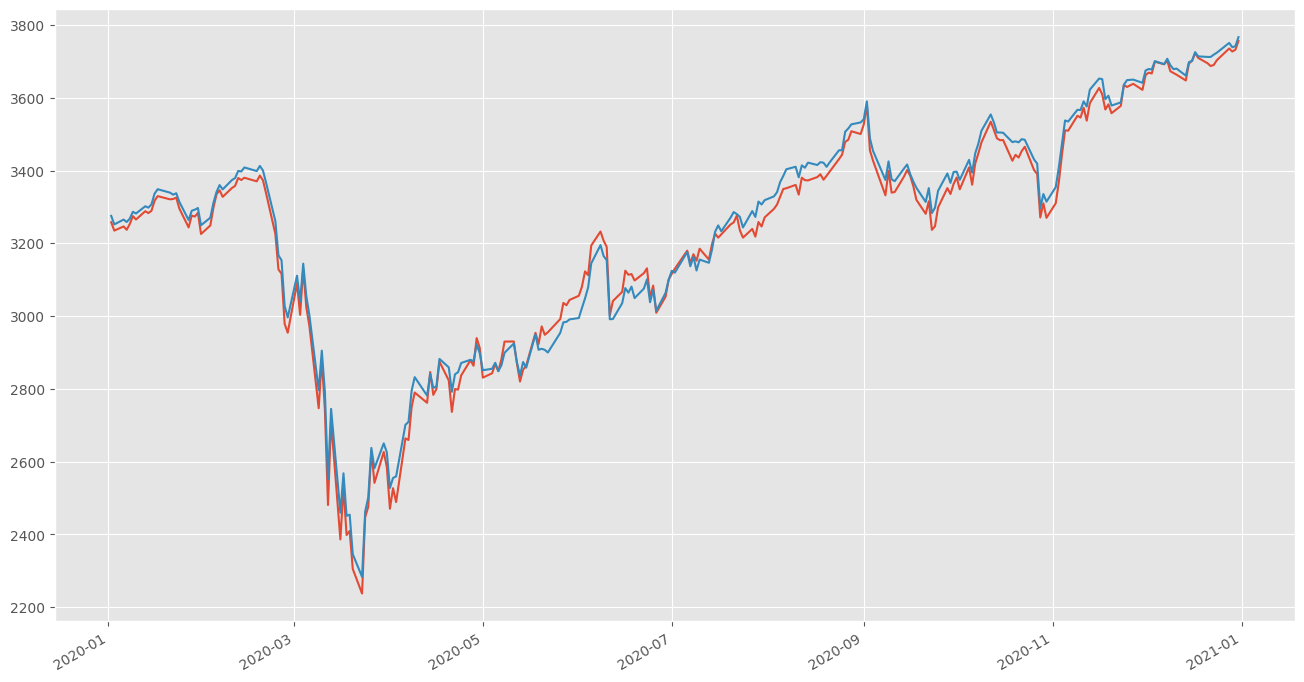

In [23]:
plot_series([data, reconstruct_absolute(data,model_output)],'2020-01-01','2020-12-31')

In [24]:
#plot_series([data.pct_change(20), reconstruct(data,model_output).pct_change(20)],'2020-01-01','2020-12-31') 

# Predicción

1990-05-10   -0.002445
1990-05-11    0.000419
1990-05-14    0.000412
1990-05-15   -0.002300
1990-05-16   -0.001051
                ...   
2025-01-27   -0.009585
2025-01-28   -0.007364
2025-01-29   -0.008353
2025-01-30   -0.004716
2025-01-31   -0.007783
Length: 8747, dtype: float64


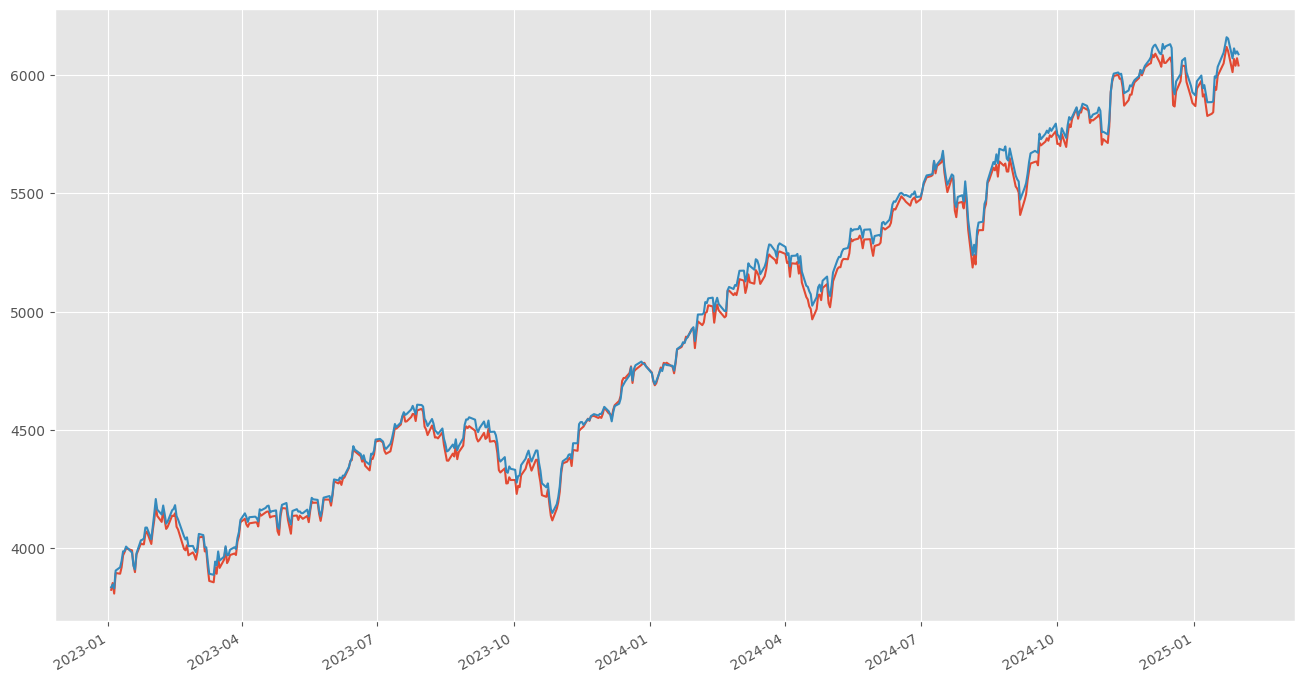

In [27]:
complete_data = ds.get_data(ticker, start_date)
model_prediction = model.get_data(ds,start_date)

print(model_prediction)

plot_series([complete_data, reconstruct_absolute(complete_data,model_prediction)], '2023-01-01')

In [ ]:
plot_series([complete_data.pct_change(20), reconstruct(complete_data,model_prediction).pct_change(20)],'2023-01-01') 